In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
import re

In [2]:
train = pd.read_csv('Data.csv')
train.head()

,UserId,TweetId,Tweet,ADR_label
0,10030778,413205,Intravenous azithromycin-induced ototoxicity.,1
1,10048291,528244,"Immobilization, while Paget's bone disease was...",1
2,10048291,361834,Unaccountable severe hypercalcemia in a patien...,1
3,10082597,292240,METHODS: We report two cases of pseudoporphyri...,1
4,10082597,467101,METHODS: We report two cases of pseudoporphyri...,1


In [3]:
#Am using a chunck from stack-overflow to remove all the unwanted digist,special characters and lower all the text to keep the
#tweets clean
def cleaned(text):
    text = re.sub(r"\n","",text)
    text = text.lower()
    text = re.sub(r"\d","",text)        #Remove digits
    text = re.sub(r'[^\x00-\x7f]',r' ',text) # remove non-ascii
    text = re.sub(r'[^\w\s]','',text) #Remove punctuation
    text = re.sub(r'http\S+|www.\S+', '', text) #Remove http
    return text

train['Tweet_clean'] = train['Tweet'].apply(lambda x : cleaned(x))

In [4]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def remove_stopwords(txt):
    txt = [word.lower() for word in txt.split() if word.lower() not in stop]
    return " ".join(txt)

train['Tweet_clean'] = train['Tweet_clean'].apply(lambda x : remove_stopwords(x))

In [5]:
# Count the max length of tweet in both train and test data for converting tweets into sequences
max_len = 0
for i in train['Tweet_clean']:
  split_i = i.split()
  if len(split_i) > max_len:
    max_len = len(split_i)

print('Max length of tweets :', max_len)

Max length of tweets : 66


In [6]:
#Droppig the original Tweet column as it is redundant
train = train.drop(['Tweet'], axis=1)
train.head()

,UserId,TweetId,ADR_label,Tweet_clean
0,10030778,413205,1,intravenous azithromycininduced ototoxicity
1,10048291,528244,1,immobilization pagets bone disease present per...
2,10048291,361834,1,unaccountable severe hypercalcemia patient tre...
3,10082597,292240,1,methods report two cases pseudoporphyria cause...
4,10082597,467101,1,methods report two cases pseudoporphyria cause...


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train['Tweet_clean'],train['ADR_label'])

In [8]:
vocab = 80000
oov = '<OOV>'
embedding = 32
padding = 'post'
truncate = 'post'

In [9]:
tokenizer = Tokenizer(num_words = vocab, oov_token = oov)
tokenizer.fit_on_texts(X_train)
#word_index = tokenizer.word_index

In [10]:
maxlength=max(len(txt) for txt in X_train)
#print(maxlength)
maxlength=20

In [11]:
X_train_tok = tokenizer.texts_to_sequences(X_train)
X_train_tok_pad = pad_sequences(X_train_tok, maxlen=maxlength, padding=padding, truncating=truncate)

X_val_tok = tokenizer.texts_to_sequences(X_val)
X_val_tok_pad = pad_sequences(X_val_tok, maxlen=maxlength, padding=padding, truncating=truncate)

y_train_values = y_train.values
y_val_values = y_val.values


In [16]:
from keras import layers 

model = tf.keras.Sequential([
    layers.Embedding(vocab, embedding, input_length=maxlength),
    layers.Dense(10, activation='relu'),
    layers.Bidirectional(layers.LSTM(128,return_sequences = True)),
    layers.LSTM(64),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(units = 10,activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(units = 1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 32)            2560000   
_________________________________________________________________
dense_3 (Dense)              (None, 20, 10)            330       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20, 256)           142336    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)               

In [17]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics=['accuracy']
)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)


In [19]:
batch_size = 1024
history = model.fit(
    X_train_tok_pad,
    y_train_values,
    epochs = 30,
    batch_size=batch_size,
    validation_data = (X_val_tok_pad, y_val_values),
    callbacks=[early_stop]
)

Epoch 1/30
18/18 [==============================] - 43s 1s/step - loss: 0.6588 - accuracy: 0.6526 - val_loss: 0.6030 - val_accuracy: 0.7069
Epoch 2/30
18/18 [==============================] - 22s 1s/step - loss: 0.5976 - accuracy: 0.7088 - val_loss: 0.5214 - val_accuracy: 0.7627
Epoch 3/30
18/18 [==============================] - 21s 1s/step - loss: 0.4633 - accuracy: 0.8065 - val_loss: 0.4049 - val_accuracy: 0.8161
Epoch 4/30
18/18 [==============================] - 22s 1s/step - loss: 0.3227 - accuracy: 0.8776 - val_loss: 0.3440 - val_accuracy: 0.8524
Epoch 5/30
18/18 [==============================] - 21s 1s/step - loss: 0.2138 - accuracy: 0.9264 - val_loss: 0.3702 - val_accuracy: 0.8512
Epoch 6/30
18/18 [==============================] - 21s 1s/step - loss: 0.1600 - accuracy: 0.9508 - val_loss: 0.3837 - val_accuracy: 0.8694


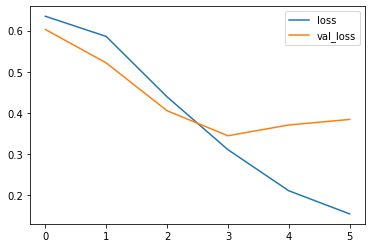

In [20]:
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
plt.show()

In [24]:
score, acc = model.evaluate(X_val_tok_pad,y_val_values, verbose = 2, batch_size = batch_size)
print("The loss of this model: %.2f" % (score))
print("The accuracy of this model: %.2f" % (acc))

6/6 - 6s - loss: 0.3837 - accuracy: 0.8694
The loss of this model: 0.38
The accuracy of this model: 0.87


In [25]:
predictions = model.predict(X_val_tok_pad)

In [29]:
print('Prediction samples', predictions[:-5])
# Show the shape of prediction, and the number of rows should be same to number of test data
#print('The shape of predictions:', predictions.shape)

Prediction samples [[0.3323053 ]
 [0.00102463]
 [0.00728279]
 ...
 [0.9599621 ]
 [0.00661716]
 [0.70113397]]


In [30]:
prediction_binary = np.round(predictions)
print('Prediction binary expression samples', prediction_binary[:-5])

# Let's turn the prediction from [0, 1] and [1, 0] into 0(negative) and 4(positive)
prediction_final = []
for each_pediction in prediction_binary:
  if each_pediction[0] == 1:
    prediction_final.append(0)
  else:
    prediction_final.append(1)

Prediction binary expression samples [[0.]
 [0.]
 [0.]
 ...
 [1.]
 [0.]
 [1.]]
